In [1]:
import multiprocessing
num_processes = multiprocessing.cpu_count()

num_processes

64

In [2]:
5 * 100_000 // 40

12500

## 変更点

* malti-label用の複数ラベル表現
    * bitをずらせば一枚の花弁でできるかな
    * Rのチャネルに1-8枚目の花弁マスクを格納
    * Gのチャネルに9-10枚目の花弁マスクを格納

In [4]:
import h5py
import numpy as np

def read_img(file_path):
    """ HDF5ファイルから10チャンネル画像を読み込む """
    with h5py.File(file_path, 'r') as file:
        image = np.array(file['image'])
    return image

def write_img(image, file_path):
    """ 10チャンネル画像をHDF5ファイルとして保存する """
    with h5py.File(file_path, 'w') as file:
        file.create_dataset('image', data=image)


In [2]:
from glob import glob
import cv2
import matplotlib.pyplot as plt
def show(img):
    plt.imshow(img)
    plt.show()

In [20]:
# %%writefile create_synthe_v4.py



import os
import glob
import math
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt
# import multi_channel_img_io

def noise(mu=0, sigma=5):
    return random.gauss(mu, sigma)

def get_raw_angles(num_petals, base_angle=137):
    """
    花弁の発生角を模した螺旋構造になるような角度配列を取得
    """
    return [base_angle * i for i in range(num_petals)]

def _sorted_devider_pairs(raw_angles):
    """
    実際の発生ロジックを満たす螺旋構造で得るための関数
    mod 360での角度と何回転目であるか(devider)を格納
    """
    return sorted([(angle % 360, angle // 360) for angle in raw_angles])

def get_ideal_angles(num_petals, base_angle=137):
    """
    花弁が等間隔に並ぶような理想的な角度配列を取得
    花弁の発生角を模した螺旋構造になる
    """
    raw_angles = get_raw_angles(num_petals, base_angle)
    # return raw_angles
    # print(raw_angles)

    sorted_angle_rank_pairs = _sorted_devider_pairs(raw_angles)
    remainder = [360 * devider for _, devider in sorted_angle_rank_pairs]
    unit_angle = 360 / num_petals

    return sorted([int(unit_angle * i + r) for i, r in enumerate(remainder)])

class SynthesisParameterConfig:
    """
    Synthesis Parameter Config class for generating synthetic data.

    Attributes:
        petals (list): List of images from the directory specified in img_petals.
        crowns (list): List of images from the directory specified in img_crowns.
        angles_list (list): List of angle_list.
    """
    def __init__(self, path_petals, path_crowns, dic_pairs):
        self.petals = self._get_imgs(path_petals)
        self.crowns = self._get_imgs(path_crowns)
        self.angles_list = self._get_angles_list(dic_pairs)

        self._standardize_petals()

    def _get_imgs(self, path_dir):
        imgs = [cv2.imread(path) for path in glob.glob(path_dir)]
        cropped_imgs = [crop_foreground(img) for img in imgs]
        refined_imgs = [refine_edge(img) for img in cropped_imgs]
        return refined_imgs

    def get_max_len(self):
        # Get dimensions of all images
        dimensions = [img.shape for img in self.petals]

        # Separate widths and heights
        widths = [dim[1] for dim in dimensions]
        heights = [dim[0] for dim in dimensions]

        # Find maximum width and height
        max_width = max(widths)
        max_height = max(heights)

        return max(max_width, max_height)

    def _standardize_petals(self):
        max_len = self.get_max_len()
        resized_imgs = []
        for img in self.petals:
            h, w = img.shape[:2]
            if h > w:
                new_size = (int(w * max_len / h), max_len)
            else:
                new_size = (max_len, int(h * max_len / w))
    
            resized_img = cv2.resize(img, new_size)
            resized_imgs.append(resized_img)
    
        self.petals = resized_imgs
        return

    def _get_angles_list(self, angles_dic):
        all_pair = [pair for pairs in dic_pairs.values() for pair in pairs]
        # print(all_pair)
        angles = [get_ideal_angles(*pair) for pair in all_pair]
        # print(angles)
        # angle_diffs = [np.diff(angle).tolist() for angle in angles]
        return angles

def refine_edge(img_rgb):
    kernel = np.ones((3,3),np.uint8)
    squared_distances = np.sum(np.square(img_rgb), axis=2)

    mask = np.where(squared_distances == 0, 0, 255)
    dilation = cv2.dilate(mask.astype(np.uint8), kernel, iterations=2)
    erosion = cv2.erode(dilation.astype(np.uint8), kernel, iterations=4)
    refined_img = cv2.bitwise_and(img_rgb, img_rgb, mask=erosion)
    
    # check_img = np.where(refined_img == 0, 255, refined_img)
    # show(check_img)
    return refined_img
    
def crop_foreground(image, pad=5):
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(grayscale, 10, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    x, y, w, h = cv2.boundingRect(contours[0])

    # Add padding to the bounding box
    x = max(0, x - pad)
    y = max(0, y - pad)
    w = min(image.shape[1] - x, w + 2*pad)
    h = min(image.shape[0] - y, h + 2*pad)

    # Crop the image using the bounding box
    cropped = image[y:y+h, x:x+w]

    return cropped


def rotate_image(image, marked_center, angle, pad):
    h, w, c = image.shape

    # Create a black square image with the same dimensions as the original image
    side = max(h, w) * 4
    square_image = np.zeros((side, side, c), dtype=np.uint8)

    # Calculate the offset for pasting the original image onto the square image
    offset_x = (side - w) // 2
    offset_y = (side - h) // 2

    # Paste the original image onto the square image
    square_image[offset_y:offset_y + h, offset_x:offset_x + w] = image

    # Calculate the position of marked_center in square_image
    square_marked_center = [marked_center[0] + offset_y, marked_center[1] + offset_x]

    # Calculate the position of the center of square_image
    square_center = [side // 2, side // 2]

    # Define the translation matrix for shifting the image
    T = np.float32([[1, 0, square_center[1] - square_marked_center[1]], [0, 1, square_center[0] - square_marked_center[0] - pad]])

    # Shift the image so that marked_center is now at the center of the image
    shifted_image = cv2.warpAffine(square_image, T, (side, side))

    # Define the rotation matrix
    # Here we adjust the center of rotation to be the center of shifted_image
    M = cv2.getRotationMatrix2D((square_center[1], square_center[0]), np.degrees(angle), 1.0)

    # Apply the rotation to the shifted image
    rotated_image = cv2.warpAffine(shifted_image, M, (side, side))
    
    return refine_edge(rotated_image)

def put_crown(img_synthetic, img_crown):
    
    # Calculate the shape of img_add and img_synthetic
    h_crown, w_crown, c_crown = img_crown.shape
    h_syn, w_syn, c_syn = img_synthetic.shape
    
    # Calculate the offset for pasting img_add onto img_synthetic
    offset_y = (h_syn - h_crown) // 2
    offset_x = (w_syn - w_crown) // 2
    
    # Create a mask for the foreground of img_add
    mask_crown = np.any(img_crown != [0, 0, 0], axis=-1)
    
    # Paste img_add onto img_synthetic using the mask
    img_synthetic[offset_y:offset_y + h_crown, offset_x:offset_x + w_crown][mask_crown] = img_crown[mask_crown]
    return img_synthetic

dic_pairs = {
    'A1': [[4, 144]],
    'A3': [[4, 100]],
    'B1': [[5, 100], [5, 137]],
    'C2': [[6, 137]],
    'D1': [[7, 100], [7, 137]],
    'E2': [[8, 100]],
    'E3': [[8, 137]],
    'F1': [[9, 100], [9, 137]],
    'G1': [[10, 137]],
}
color = '黄色丸'

config = SynthesisParameterConfig(
    f'work/data/petals/{color}/*.png',
    f'work/data/petals/{color}/crown/*.png',
    dic_pairs
)

max_len = config.get_max_len()
side = max_len * 4
padding_size = 6
n_sample_petal = 3
NUM_CREATE = 100
sigma = 0.15

# サンプルの設定値を使ってインスタンスを作成
synthe_flw_dir = f'work/data/synthetic_flw/flw/{color}'
synthe_mask_dir = f'work/data/synthetic_flw/mask/{color}'
os.makedirs(synthe_flw_dir, exist_ok=True)
os.makedirs(synthe_mask_dir, exist_ok=True)
os.makedirs(f'{synthe_mask_dir}_10c', exist_ok=True)
# color = '紫'

for j in range(NUM_CREATE):
    img_synthetic = np.zeros((side, side, 3), dtype=np.uint8)
    img_crown = random.choice(config.crowns)
    img_crown = cv2.resize(img_crown, (int(max_len * 0.5), int(max_len * 0.5)))
    angles = random.choice(config.angles_list)
    # print(angles)

    # turn on below if use single petal
    petals = random.choices(config.petals, k=n_sample_petal)
    synthetic_masks = []
    # agg_synthetic_mask = np.zeros((side, side), dtype=np.uint8)
    for i, angle in enumerate(angles):
        synthetic_mask = np.zeros((side, side), dtype=np.uint8)
            
        # turn on below if use various petals
        petal = random.choice(petals)
        h, w, c = petal.shape
        petal_img_center = [int(h * 0.95), int(w * 0.5)]

        # petal augumentation
        petal_ = petal.copy()
        if np.random.randint(2):
            petal_ = cv2.flip(petal_, 1)
            
        fx = random.gauss(1, sigma)
        fy = random.gauss(1, sigma)
        petal_ = cv2.resize(petal_, dsize=None, fx=fx, fy=fy)

        pad = padding_size # Replace with your desired padding
        angle += noise(mu=0, sigma=10)
        # print(angle)
        angle_radian = math.radians(angle)
        
        result = rotate_image(petal, petal_img_center, angle_radian, pad)
        square_center = [int(side // 2) for s in result.shape[:2]]
        # marked_result = mark_center(result, square_center, color=(255, 255, 0))
        marked_result = result
    
        # Define a mask for the foreground of the new image
        mask_new = np.any(marked_result != [0, 0, 0], axis=-1)
    
        # Compute the center of synthetic image and center of marked_result
        synthetic_center = [s // 2 for s in img_synthetic.shape[:2]]
        top_left = [synthetic_center[0] - square_center[0], synthetic_center[1] - square_center[1]]
    
        # Use the mask to overwrite the pixels of the synthetic image with the pixels of the new image
        img_synthetic[top_left[0]:top_left[0] + marked_result.shape[0], top_left[1]:top_left[1] + marked_result.shape[1]][mask_new] = marked_result[mask_new]
    
        # Define a mask for the foreground of the new image
        mask_new = np.any(marked_result != [0, 0, 0], axis=-1)
    
        # Compute the center of synthetic image and center of marked_result
        synthetic_center = [s // 2 for s in img_synthetic.shape[:2]]
        top_left = [synthetic_center[0] - square_center[0], synthetic_center[1] - square_center[1]]
    
        # Use the mask to overwrite the pixels of the mask image with i+1
        synthetic_mask[top_left[0]:top_left[0] + marked_result.shape[0], top_left[1]:top_left[1] + marked_result.shape[1]][mask_new] = 1
        # agg_synthetic_mask[top_left[0]:top_left[0] + marked_result.shape[0], top_left[1]:top_left[1] + marked_result.shape[1]][mask_new] = i + 1
        synthetic_masks.append(synthetic_mask)

    channel = len(synthetic_masks) + 1
    [synthetic_masks.append(np.zeros((side, side), dtype=np.uint8)) for _ in range(10 - channel)]
    mask_10c = np.stack(synthetic_masks, -1)
    
    img_synthetic = put_crown(img_synthetic, img_crown)
    # show(cv2.cvtColor(img_synthetic, cv2.COLOR_BGR2RGB))
    cv2.imwrite(f'{synthe_flw_dir}/{str(j).zfill(6)}.png', img_synthetic)
    # cv2.imwrite(f'{synthe_mask_dir}/{str(j).zfill(6)}.png', agg_synthetic_mask)
    write_img(mask_10c, f'{synthe_mask_dir}_10c/{str(j).zfill(6)}.h5')

In [6]:
for i in range(10):
    print((agg_synthetic_mask == i).sum())

1648317
13361
20072
5255
5197
19040
47638
56447
76428
68245


In [7]:
mask_aggregated = np.stack(synthetic_masks, -1)

In [26]:
def write_img(image, file_path):
    """ 10チャンネル画像をHDF5ファイルとして保存する """
    with h5py.File(file_path, 'w') as file:
        file.create_dataset('image', data=image)
# write_multichannel_image(mask_aggregated, './path_to_save_image.h5')
write_img(mask_aggregated, './path_to_save_image.h5')

In [8]:
# mask = read_multichannel_image('./path_to_save_image.h5')
mask = read_img('./path_to_save_image.h5')

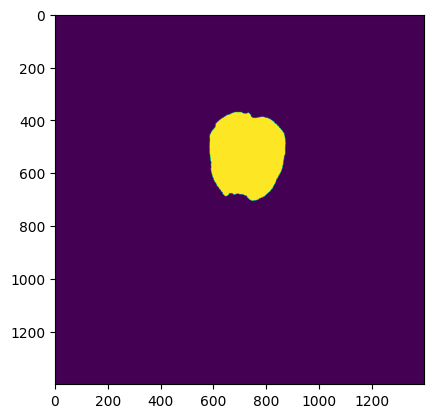

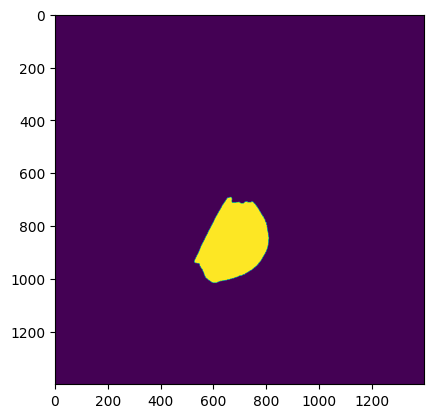

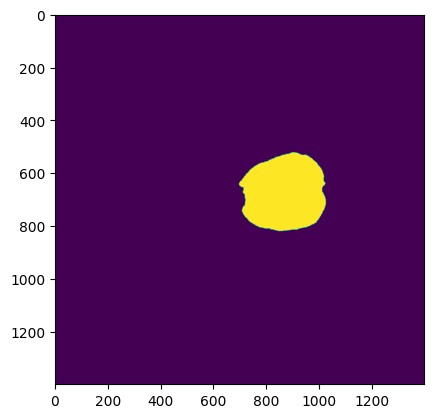

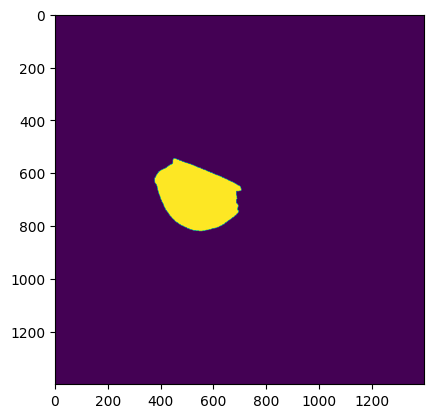

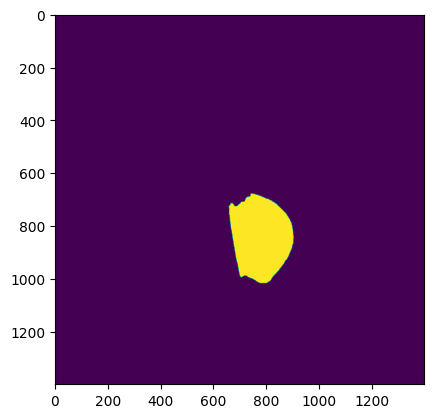

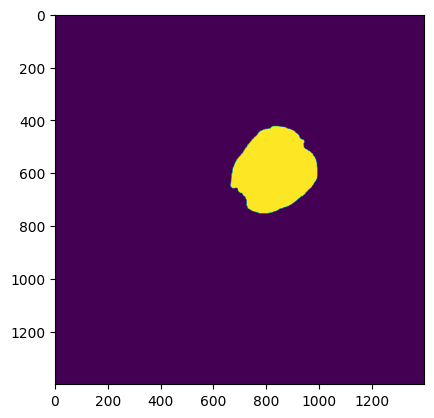

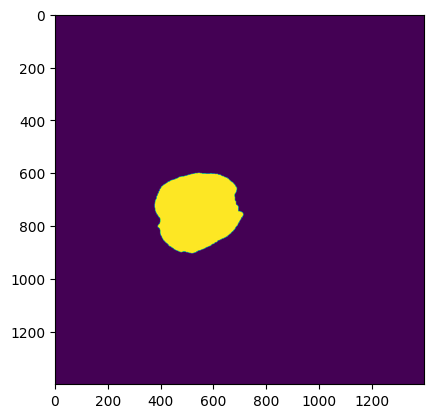

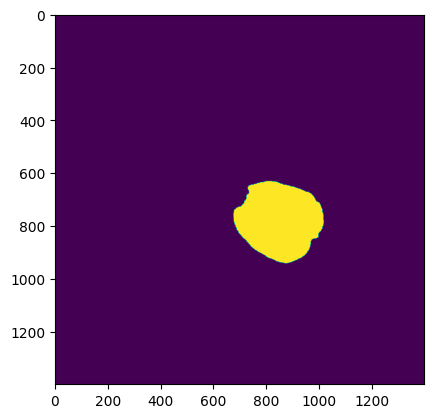

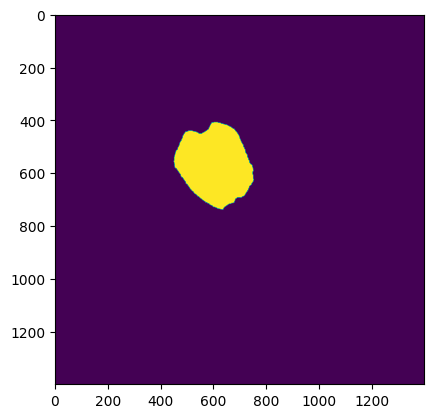

IndexError: index 9 is out of bounds for axis 2 with size 9

In [9]:
for i in range(10):
    show(mask_10c[:, :, i])

In [10]:
mask_synthetic_b = np.zeros_like(img_synthetic[:, :, 0])

mask = np.stack([mask_synthetic_b, mask_synthetic_g, mask_synthetic_r], -1)
print(f'{mask.shape=}')
show(mask)

cv2.imwrite('./mask_sample.png', mask)

NameError: name 'mask_synthetic_g' is not defined

In [31]:
import cv2
import numpy as np

mask = cv2.imread('./mask_sample.png')
mask_r = mask[:, :, 2]
mask_g = mask[:, :, 1]

mask_agg = mask_r + mask_g * 2 ** 8

show(mask_r)
show(mask_g)

[ WARN:0@2228.878] global loadsave.cpp:241 findDecoder imread_('./mask_sample.png'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable

In [32]:
i = 2
5 & (1 << i) >> i

1

In [33]:
bit_images = []
for i in range(8):
    # 各ビットを抽出し、0か255の値に変換
    bit_image = ((mask_r & (1 << i)) >> i) * 255
    bit_images.append(bit_image)

    # 画像を表示または保存
    cv2.imshow(f'Bit {i} Image', bit_image)
    cv2.imwrite(f'bit_{i}_image.jpg', bit_image)

NameError: name 'mask_r' is not defined

In [34]:
masks = []
for i in range(10):
    val = 2 ** (10 - i - 1)
    mask = np.where(mask_agg > val, 1, 0)
    mask_agg[mask] -= val
    masks.append(mask)
    show(mask)

NameError: name 'mask_agg' is not defined

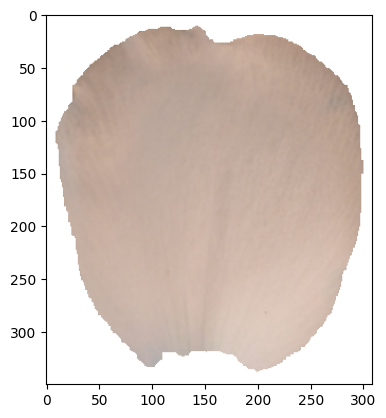

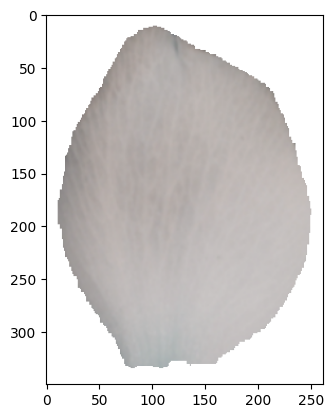

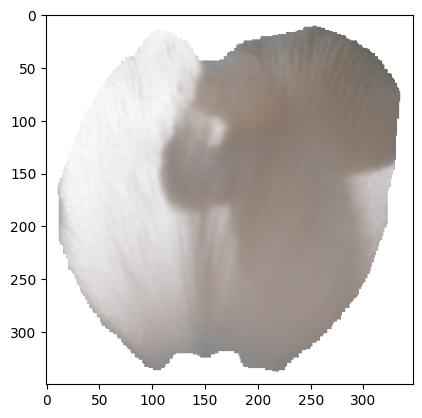

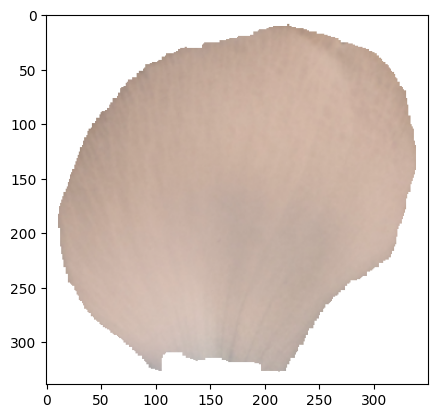

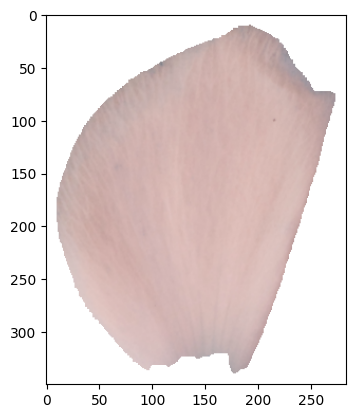

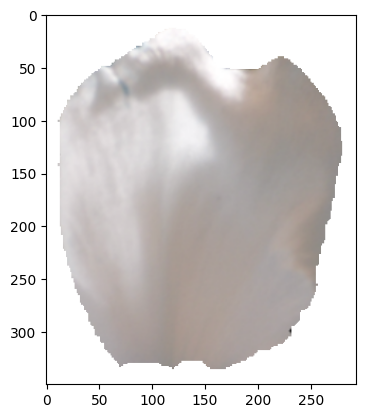

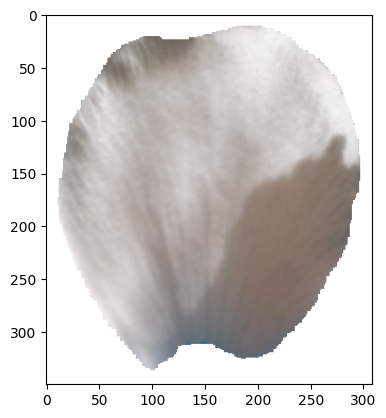

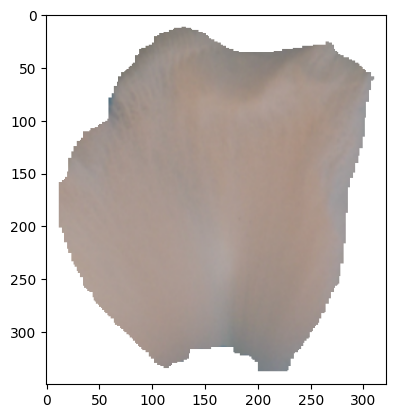

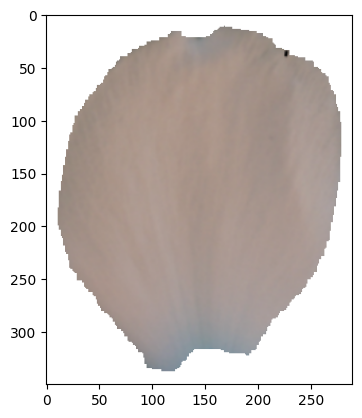

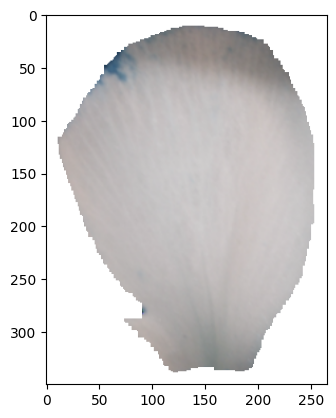

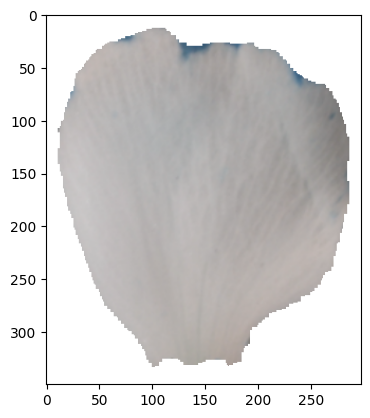

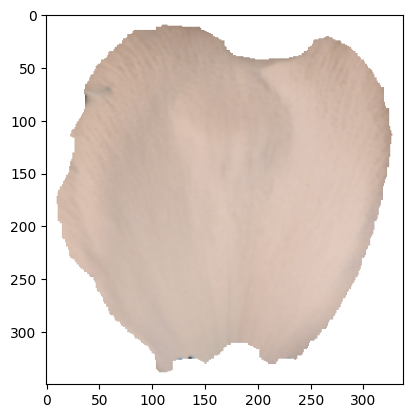

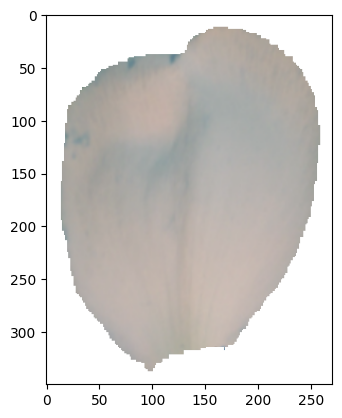

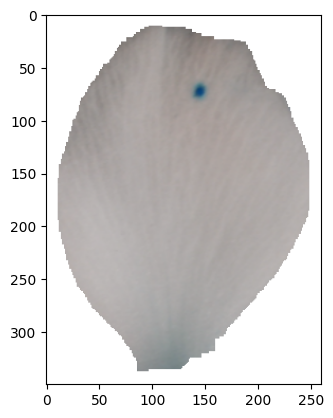

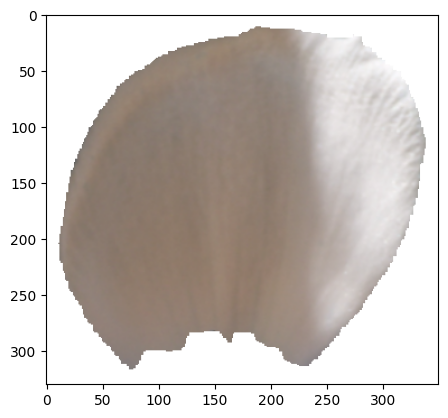

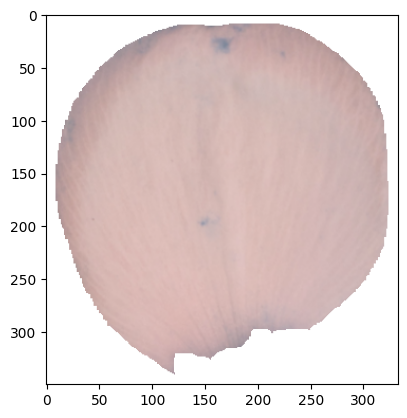

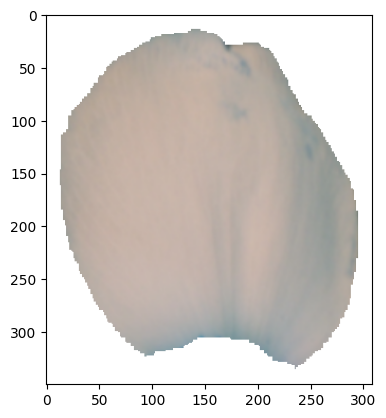

In [35]:
# config = SynthesisParameterConfig(
#     f'../petals/{color}/*.png',
#     f'../petals/{color}/crown/*.png',
#     dic_pairs
# )

for petal in config.petals:
    petal = refine_edge(petal)
    check_img = np.where(petal == 0, 255, petal)
    show(check_img)

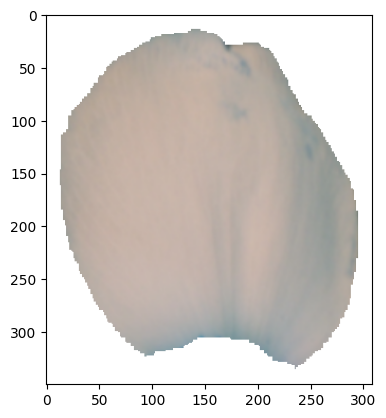

In [36]:
white_bg_petal = np.where(petal == 0, 255, petal)
show(white_bg_petal)

In [37]:
white_bg_petal.shape

(350, 309, 3)

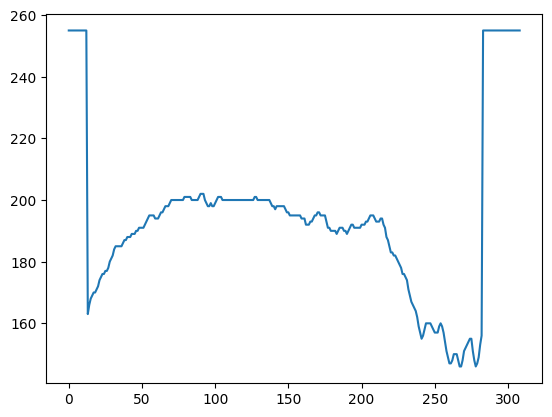

In [38]:
l = len(white_bg_petal[150, :, 0])
x = np.arange(l)

plt.plot(x, white_bg_petal[150, :, 0])

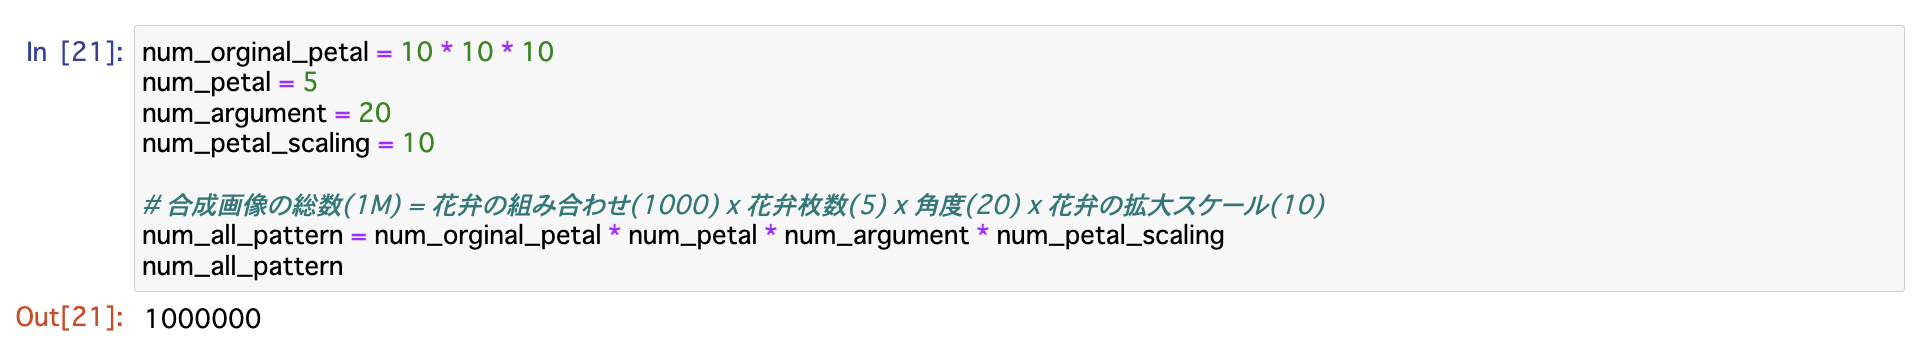

In [21]:
# 1枚の花弁の整形にn分かかるとすると

n = 2
n * 1000 // 60

33

In [17]:
# 100枚の合成画像で3分
3 / 100 * 60
# 1枚あたりの合成時間 1.8秒

1.7999999999999998